# ROC curves and accuracy curves (HST training set)

In this notebook we show ROC curves and accuracy curves of several star/galaxy separation models: the machine leaarning model, the simple model (based on wwpsfKronDist), and PS1 model (based on $m_{\mathrm{iPSF}} - m_{\mathrm{iKron}}$). 

Simple model outperforms PS1 model, and the machine learning model shows the best performance in all range of brightness.

In [216]:
import sys,os,math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams["font.family"] = "sans-serif"
rcParams['font.sans-serif'] = ['DejaVu Sans']
from matplotlib import gridspec as grs
from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


from astropy.table import Table
import seaborn as sns
import statsmodels.nonparametric.api as smnp
from statsmodels.nonparametric.kernel_density import KDEMultivariate
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, accuracy_score, auc, roc_auc_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from scipy import interp

%matplotlib notebook

Functions to plot ROC curves and accuracy curves.  

In [24]:
def calc_CV_ROC(features, GT, score, n_splits, ML=False, classifier=None):
    cv = StratifiedKFold(n_splits=n_splits)
    tprs = []
    mean_fpr = np.linspace(0, 1, 5000)

    i = 0
    print('\n CV: ', end=' ')
    for train, test in cv.split(features, GT):
        print('%d/%d, '%(i+1, n_splits), end='')
        X_train, X_test, y_train, y_test = features[train], features[test], GT[train], GT[test]
        if ML: 
            score = np.array(classifier.fit(X_train, y_train).predict_proba(X_test))
            score = score[:, 1]            
            fpr, tpr, thresholds = roc_curve(y_test, score)
        else:
            fpr, tpr, thresholds = roc_curve(y_test, np.array(score)[test])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        i += 1

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0

    std_tpr = np.std(tprs, axis=0)/np.sqrt(n_splits)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    
    return(mean_fpr, mean_tpr, tprs_lower, tprs_upper)

def plot_ROC_curves(catalog, features, GT, n_splits, classifier, 
                    figname, savefig, 
                    extent =  [0, 1, 0, 1], extent_ins = [3e-3, 0.98e-2, 0.6, 0.78]):
    
    ML_mean_fpr, ML_mean_tpr, ML_tprs_lower, ML_tprs_upper =\
        calc_CV_ROC(np.array(features), GT, None, n_splits, ML=True, classifier=classifier)    
    dist_mean_fpr, dist_mean_tpr, dist_tprs_lower, dist_tprs_upper =\
        calc_CV_ROC(np.array(features), GT, catalog.wwPSFKronDist, n_splits)
    i_mean_fpr, i_mean_tpr, i_tprs_lower, i_tprs_upper =\
        calc_CV_ROC(np.array(features), GT, -catalog.iPSFminusKron, n_splits)
    
    col_ML = 'black'
    col_dist = "C0"
    col_iminus = "C1"
    col_star = 'red'

    fig, ax = plt.subplots(figsize=(8, 5))
    axins = inset_axes(ax, width="58.5%",  
                       height="67.5%", loc=5)

    ax.grid(alpha=0.5, lw=0.5, c='grey', linestyle=':') 
    ax.tick_params(which="both", top=True, right=True)
    ax.minorticks_on()
    
    ax.fill_between(ML_mean_fpr, ML_tprs_lower, ML_tprs_upper, color=col_ML, alpha=.5)
    ax.fill_between(dist_mean_fpr, dist_tprs_lower, dist_tprs_upper, color=col_dist, alpha=.5)
    ax.fill_between(i_mean_fpr, i_tprs_lower, i_tprs_upper, color=col_iminus, alpha=.5)
    ax.plot(ML_mean_fpr, ML_mean_tpr, color=col_ML, lw=1, label='ML model')
    ax.plot(dist_mean_fpr, dist_mean_tpr, color=col_dist, lw=1, label='Simple model')
    ax.plot(i_mean_fpr, i_mean_tpr, color=col_iminus, lw=1, label='PS1 model')# label=r'm$_{\rm iPSF}-$m$_{\rm iKron}$')
    #ax.plot(i_mean_fpr[np.argmin(np.abs(i_thre--0.05))], 
    #    i_tpr[np.argmin(np.abs(i_thre--0.05))], '*', color=col_star_dist)

    ax.set_xlim(extent[0:2]); ax.set_ylim(extent[2:4])
    ax.tick_params(labelsize = 15)
    ax.set_xlabel('False Positive Ratio', fontsize=15)
    ax.set_ylabel('True Positive Ratio', fontsize=15)

    ax.legend( bbox_to_anchor=(0.01, 0.01, 1., 0.102), 
              loc=3, borderaxespad=0, fontsize=13)
    
    origin = 'lower'
    axins.tick_params(which="both", top=True)
    axins.minorticks_on()
    axins.fill_between(ML_mean_fpr, ML_tprs_lower, ML_tprs_upper, color=col_ML, alpha=.5)
    axins.fill_between(dist_mean_fpr, dist_tprs_lower, dist_tprs_upper, color=col_dist, alpha=.5)
    axins.fill_between(i_mean_fpr, i_tprs_lower, i_tprs_upper, color=col_iminus, alpha=.5)
    axins.plot(ML_mean_fpr, ML_mean_tpr, color=col_ML, lw=1.5)
    axins.plot(dist_mean_fpr, dist_mean_tpr, color=col_dist, lw=1.5)
    axins.plot(i_mean_fpr, i_mean_tpr, color=col_iminus, lw=1.5)
    axins.vlines([5e-3], 1e-3, 1, color='grey', lw=0.5)
    axins.set_xlim(extent_ins[0:2]); axins.set_ylim(extent_ins[2:4])
    axins.tick_params(labelsize = 15)
    plt.tight_layout()
    
    if savefig: 
        plt.savefig(figname)
    
    plt.show()
    
    return(None)

def calc_separtion_thre(thre, tpr, fpr, method):
    if method == 'info':
        return(thre[(tpr-fpr)==np.max(tpr-fpr)]-1e-10)
    if method == 'fom':
        return(thre[np.argmin(np.abs(fpr-0.005))])

def make_separation_label(thre, proba):
    return((np.sign(proba - thre).astype(int) + 1)/2)

def calc_accuracy_error(GT, labels, Xval, Xmin, Xmax, binwidth = 0.5, Nboot = 1):
    X_array = np.arange(Xmin , Xmax+binwidth, binwidth)
    acc_arr = np.zeros_like(X_array)
    boot_scatt = np.vstack((np.zeros_like(X_array), np.zeros_like(X_array)))

    for bin_num, binedge in enumerate(X_array):
        bin_sources = np.where((Xval >= binedge) & (Xval < binedge + binwidth))
        acc_arr[bin_num] = accuracy_score(GT[bin_sources], 
                                               labels[bin_sources])
        boot_acc = np.empty(Nboot)
        for i in range(Nboot):
            boot_sources = np.random.choice(bin_sources[0], len(bin_sources[0]))
            boot_acc[i] = accuracy_score(GT[boot_sources], 
                                                   labels[boot_sources])

        boot_scatt[:,bin_num] = np.percentile(boot_acc, [16, 84])
    return(X_array+binwidth/2, acc_arr, boot_scatt)

def calc_CV_accuracy(features, catalog, GT, labels, Xval, Xmin, Xmax, binwidth = 0.5, n_splits=10, ML=False, classifier=None):
    cv = StratifiedKFold(n_splits=n_splits)
    X_array = np.arange(Xmin , Xmax+binwidth, binwidth)
    acc_arr = np.zeros_like(X_array)
    cv_tab = np.zeros((len(X_array), n_splits))
    
    i=0
    for train, test in cv.split(features, GT):
        print(i, end='')
        if ML: 
            X_train, X_test, y_train, y_test = \
                np.array(features)[train], np.array(features)[test], np.array(GT)[train], np.array(GT)[test]
            labels = classifier.fit(X_train, y_train).predict(X_test)
        boot_acc = np.empty(len(X_array))
        for bin_num, binedge in enumerate(X_array):
            bin_sources = np.where((np.array(Xval)[test] >= binedge) & (np.array(Xval)[test] < binedge + binwidth))
            if ML: 
                boot_acc[bin_num] = accuracy_score(y_test[bin_sources], labels[bin_sources])
            else: 
                boot_acc[bin_num] = accuracy_score(np.array(GT)[test][bin_sources], np.array(labels)[test][bin_sources])
        cv_tab[:, i] = boot_acc
        i += 1
    cv_mean = np.mean(cv_tab, axis=1)
    cv_std = np.std(cv_tab, axis=1)/np.sqrt(n_splits)
    return(X_array+binwidth/2, cv_mean, cv_std)

def plot_ACU_curves(features, catalog, GT, figname, savefig, thre_method='info'):
    
    wwKronMag =  -2.5*np.log10(catalog.wwKronFlux/3631)
    
    #dist_fpr, dist_tpr, dist_thre = roc_curve(GT, catalog.wwPSFKronDist)
    #dist_thre_info  = 9.2e-07 #calc_separtion_thre(dist_thre, dist_tpr, dist_fpr, method=thre_method)

    dist_labels = make_separation_label(9.2e-07, catalog.wwPSFKronDist.values)
    iminus_labels = make_separation_label(-0.05, -catalog.iPSFminusKron.values)
    
    print('Calculating the error of the accuracy: ', end='')
    mag_array, ML_acc_arr, ML_boot_scatt = \
        calc_CV_accuracy(features, catalog, GT, None, wwKronMag, 14.75, 23.25, ML=True, classifier=classifier)
    mag_array, dist_acc_arr, dist_boot_scatt = \
        calc_CV_accuracy(features, catalog, GT, dist_labels, wwKronMag, 14.75, 23.25)
    mag_array, iminus_acc_arr, iminus_boot_scatt = \
        calc_CV_accuracy(features, catalog, GT, iminus_labels, wwKronMag, 14.75, 23.25)
    print('Done.')
    
    print('Calculating PDFs : ', end='')
    star_norm = np.sum(GT==1)/len(GT)
    gal_norm = np.sum(GT==0)/len(GT)
    
    All_kde = stats.gaussian_kde(wwKronMag)
    Star_kde = stats.gaussian_kde(wwKronMag[GT==1])
    Gal_kde = stats.gaussian_kde(wwKronMag[GT==0])
    n = (np.arange(12,25,0.1))
    All_kde_pdf = All_kde(n)
    Star_kde_pdf = Star_kde(n)*star_norm
    Gal_kde_pdf = Gal_kde(n)*gal_norm
    print('Done.\n')
    
    bias = 0.5

    cmap_star = sns.cubehelix_palette(rot=0.5, light=0.7,dark=0.3,as_cmap=True)
    cmap_gal = sns.cubehelix_palette(start=0.3,rot=-0.5,light=0.7,dark=0.3,as_cmap=True)

    col_ML = 'black'
    col_dist = "C0"
    col_iminus = "C1"

    plt.figure(figsize=(8,5))
    
    plt.fill(n, All_kde_pdf + bias, alpha=0.5, color="0.7", zorder=0)
    plt.fill(n, Gal_kde_pdf + bias, alpha=0.8, color=cmap_gal(0.25), zorder=1)
    plt.fill(n, Star_kde_pdf + bias, alpha=0.8, color=cmap_star(0.25), zorder=2)

    plt.vlines(mag_array, iminus_acc_arr - iminus_boot_scatt,  iminus_acc_arr + iminus_boot_scatt, 
               color=col_iminus, alpha=0.5, linewidth=1, zorder=3)
    plt.vlines(mag_array, dist_acc_arr - dist_boot_scatt, dist_acc_arr + dist_boot_scatt, 
               color=col_dist, alpha=0.5, linewidth=1, zorder=4)
    plt.vlines(mag_array, ML_acc_arr - ML_boot_scatt, ML_acc_arr + ML_boot_scatt, 
               color=col_ML, alpha=0.5, linewidth=1, zorder=5)
    plt.plot(mag_array, dist_acc_arr, color=col_dist, alpha=0.5, linewidth=0.5, zorder=6)
    plt.plot(mag_array, ML_acc_arr, color=col_ML, alpha=0.5, linewidth=0.5, zorder=7)
    plt.plot(mag_array, iminus_acc_arr, color=col_iminus, alpha=0.5, linewidth=0.5, zorder=8)
    plt.scatter(mag_array, ML_acc_arr, color=col_ML, label='ML model', zorder=11)
    plt.scatter(mag_array, dist_acc_arr, color=col_dist, label='Simple model', zorder=10)
    plt.scatter(mag_array, iminus_acc_arr, color=col_iminus, label='PS1 model', zorder=9)#, label = r'm$_{\rm iPSF}-$m$_{\rm iKron}$')

    plt.ylim(bias,1.01)
    plt.xlim(14.5, 24.0)
    plt.legend(bbox_to_anchor=(0.01, 0.3, 1., 0.102), loc=3, fontsize=13)
    plt.tick_params(labelsize = 15, which="both", top=True,  right=True)
    plt.minorticks_on()
    plt.xlabel('whiteKronMag', fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.tight_layout()
    
    if savefig:
        plt.savefig(figname)
        
    plt.show()
    return(None)

def check_ROC_Accuracy(TrainingCatalog, TestingCatalog, FeatureNames, TrainingGT, TestingGT, 
                      n_estimators = 250, min_samples_leaf = 1, max_features = 5, 
                      TrainMask=None, TestMask=None,  clean=True, 
                      saveROCfig=True, saveAccuraccyfig=True, FigName='Auto'):
    import warnings
    warnings.filterwarnings('ignore')
    
    print("""Running the model with
    %s
    Using clean dataset = %s 
    Parameters for the random forest classifier: 
    n_estimators = %d 
    min_samples_leaf = %d
    max_features = %d \n""" 
          %(FeatureNames, clean, n_estimators, min_samples_leaf, max_features))
    
    if len(TrainMask) == len(TrainingCatalog):
        TrainingCatalog = TrainingCatalog[TrainMask]
        TrainingGT = TrainingGT[TrainMask]
    if len(TestMask) == len(TestingCatalog):
        TestingCatalog = TestingCatalog[TestMask]
        TestingGT = TestingGT[TestMask]
    
    tr_tab = TrainingCatalog.loc[:,FeatureNames]
    te_tab = TestingCatalog.loc[:,FeatureNames]
    
    print("""Length of the datasets:
    Training: %d 
    Testing: %d \n""" %(len(tr_tab), len(te_tab)))
    
    tr_X = tr_tab.values
    tr_Y = np.squeeze(TrainingGT)
    te_X = te_tab.values
    te_Y = np.squeeze(TestingGT)
        
    print('Training the classifier: ', end='')
    Classifier = RandomForestClassifier(n_estimators = n_estimators, 
                                                        min_samples_leaf = min_samples_leaf, 
                                                        max_features= max_features, n_jobs=-1).fit(tr_X, tr_Y)
    print('Done.\n')
    
    if  FigName=='Auto':
        figname = str(n_estimators) + '_' + str(min_samples_leaf) + '_' + str(max_features)
        if clean:
            figname = figname + '_clean'
        ROC_figname = 'ROC_' + figname + '.pdf'
        ACU_figname = 'ACU_' + figname + '.pdf'
                                        
    ML_predict = Classifier.predict_proba(te_X)
    print('Plotting ROC curves: ')
    plot_ROC_curves(TestingCatalog, te_Y, ML_predict[:,1], ROC_figname, saveROCfig)
    print('Plotting accuracy curves: ')
    plot_ACU_curves(TestingCatalog, te_Y, ML_predict[:,1], ACU_figname, saveAccuraccyfig)
    
    return(None)

In [4]:
hst_tab = Table.read("HST_COSMOS_features_adamamiller.fit").to_pandas()

In [64]:
hst_GT = np.array(hst_tab.MU_CLASS - 1, dtype=int)

For a fair comparison between the 3 models we must generate a subset of sources that has a classification from each model. 

In [65]:
hst_det_mask = (hst_tab.nDetections > 0)&\
    (hst_tab.wwPSFFlux>0) & (hst_tab.wwKronFlux>0) & (hst_tab.wwApFlux>0)&\
    (~np.isnan(hst_tab.iPSFminusKron))

In [66]:
print("There are {:d} sources in the PS1 subset from HST".format(sum(hst_det_mask)))

There are 40098 sources in the PS1 subset from HST


## Without flux information (All dataset)

In [67]:
fnames = ['psfChiSq', 'ExtNSigma', 'psfLikelihood',
          'PSFKronRatio', 'PSFKronDist',  'PSFApRatio',
          'momentRH', 'momentXX', 'momentXY', 'momentYY', 
          'KronRad']
fil = 'ww'
features = [fil  + feat for feat in fnames]


 CV:  1/10, [[ 0.889875    0.110125  ]
 [ 0.99833333  0.00166667]
 [ 0.99479167  0.00520833]
 ..., 
 [ 0.04833333  0.95166667]
 [ 0.99475     0.00525   ]
 [ 0.82203571  0.17796429]]
2/10, [[ 0.16822619  0.83177381]
 [ 0.51025     0.48975   ]
 [ 0.003125    0.996875  ]
 ..., 
 [ 1.          0.        ]
 [ 0.95579167  0.04420833]
 [ 0.99729167  0.00270833]]
3/10, [[ 0.10704167  0.89295833]
 [ 0.001       0.999     ]
 [ 0.271375    0.728625  ]
 ..., 
 [ 0.61054167  0.38945833]
 [ 1.          0.        ]
 [ 0.86362716  0.13637284]]
4/10, [[ 0.00525     0.99475   ]
 [ 0.38064583  0.61935417]
 [ 0.96997024  0.03002976]
 ..., 
 [ 0.96479167  0.03520833]
 [ 0.98970833  0.01029167]
 [ 0.99222917  0.00777083]]
5/10, [[ 0.4345873   0.5654127 ]
 [ 0.          1.        ]
 [ 0.80921429  0.19078571]
 ..., 
 [ 0.87379167  0.12620833]
 [ 0.97875     0.02125   ]
 [ 0.989625    0.010375  ]]
6/10, [[ 0.638625    0.361375  ]
 [ 0.          1.        ]
 [ 0.33249702  0.66750298]
 ..., 
 [ 0.8875      0.11

<IPython.core.display.Javascript object>


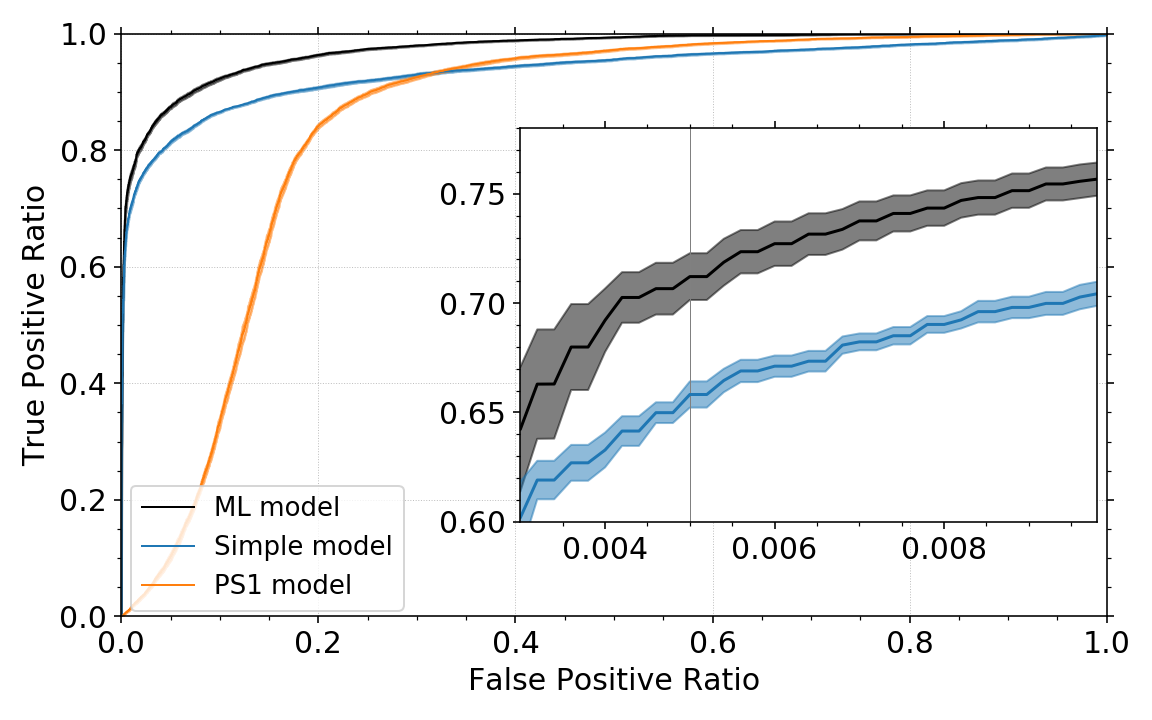

/Users/adamamiller/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [69]:
classifier = RandomForestClassifier(n_estimators = 400, 
                                                    min_samples_leaf = 2, 
                                                    max_features= 4, n_jobs=-1)

plot_ROC_curves(hst_tab[hst_det_mask], hst_tab[hst_det_mask][features], hst_GT[np.array(hst_det_mask)], 
                n_splits=10, classifier=classifier, figname='CV_ROC_HST.pdf', savefig = False)

The FoM (FPR = 0.005) of the ML model and the simple model is $\sim 0.71$ and $\sim 0.66$, while that of the PS1 model is almost 0. 

Calculating the error of the accuracy: 012345678901234567890123456789Done.
Calculating PDFs : Done.



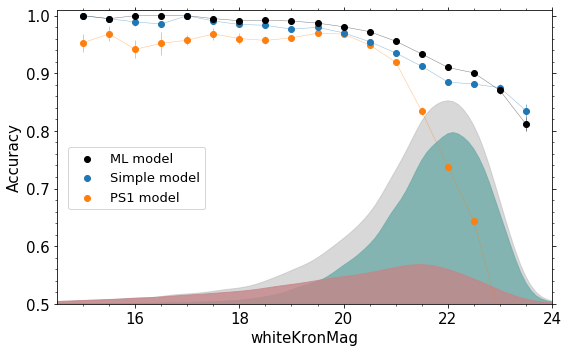

In [44]:
plot_ACU_curves(hst_tab[hst_det_mask][features], hst_tab[hst_det_mask], hst_GT[hst_det_mask], 
                figname='CV_Accuracy_HST.pdf', savefig=True, thre_method='info')

## Adjustments

Make a slight alteration to the primary calculation in order to retain information about the individual folds and the statistics computed from each of them.

In [141]:
def get_CV_preds(hst_tab, hst_det_mask, feats, n_splits=10, rs=23):
    ps1_preds = np.array(hst_tab["iPSFminusKron"].loc[hst_det_mask])
    simple_preds = np.array(hst_tab["wwPSFKronDist"].loc[hst_det_mask])
    X_hst = np.array(hst_tab[feats].loc[hst_det_mask])
    y_hst = np.array(hst_tab["MU_CLASS"].loc[hst_det_mask] - 1, dtype=int)
    rf_preds = np.empty_like(simple_preds)
    cv = StratifiedKFold(n_splits=n_splits, random_state=rs)
    for train, test in cv.split(X_hst, y_hst):
        rf_preds[test] = classifier.fit(X_hst[train], 
                                        y_hst[train]).predict_proba(X_hst[test])[:,1]
    return y_hst, ps1_preds, simple_preds, rf_preds

In [142]:
y_hst, ps1_preds, simple_preds, rf_preds = get_CV_preds(hst_tab, hst_det_mask, features, n_splits=10, rs=23)

In [96]:
def calc_fom(fpr, tpr, thresh):
    return interp(0.005, fpr, tpr)

In [294]:
def calc_summary_stats(y_hst, ps1_preds, simple_preds, rf_preds, 
                       ps1_ct = 0.05, 
                       simple_ct = 9.2e-7,
                       rf_ct = 0.5,
                       make_plot = False,
                       fold_plot = True):
    ps1_fpr, ps1_tpr, ps1_thresh = roc_curve(y_hst, -1*ps1_preds)
    ps1_fom = calc_fom(ps1_fpr, ps1_tpr, ps1_thresh)
    ps1_auc = roc_auc_score(y_hst, -1*ps1_preds)
    ps1_acc = accuracy_score(y_hst, ps1_preds <= ps1_ct)
    
    simple_fpr, simple_tpr, simple_thresh = roc_curve(y_hst, simple_preds)
    simple_fom = calc_fom(simple_fpr, simple_tpr, simple_thresh)
    simple_auc = roc_auc_score(y_hst, simple_preds)
    simple_acc = accuracy_score(y_hst, simple_preds >= simple_ct)
    
    rf_fpr, rf_tpr, rf_thresh = roc_curve(y_hst, rf_preds)
    rf_fom = calc_fom(rf_fpr, rf_tpr, rf_thresh)
    rf_auc = roc_auc_score(y_hst, rf_preds)
    rf_acc = accuracy_score(y_hst, rf_preds >= rf_ct)
    
    if make_plot:
        lw = 0.5 if fold_plot else 2
        alpha = 0.4 if fold_plot else 1
        for ax in [main_ax, axins]:
            ax.plot(rf_fpr, rf_tpr, lw=lw, color="#7570b3", alpha=alpha)
            ax.plot(simple_fpr, simple_tpr, lw=lw, color="#1b9e77", alpha=alpha)
            ax.plot(ps1_fpr, ps1_tpr, lw=lw, color="#34495e", alpha=alpha)

    
    return ps1_auc, ps1_acc, ps1_fom, simple_auc, simple_acc, simple_fom, rf_auc, rf_acc, rf_fom

<IPython.core.display.Javascript object>


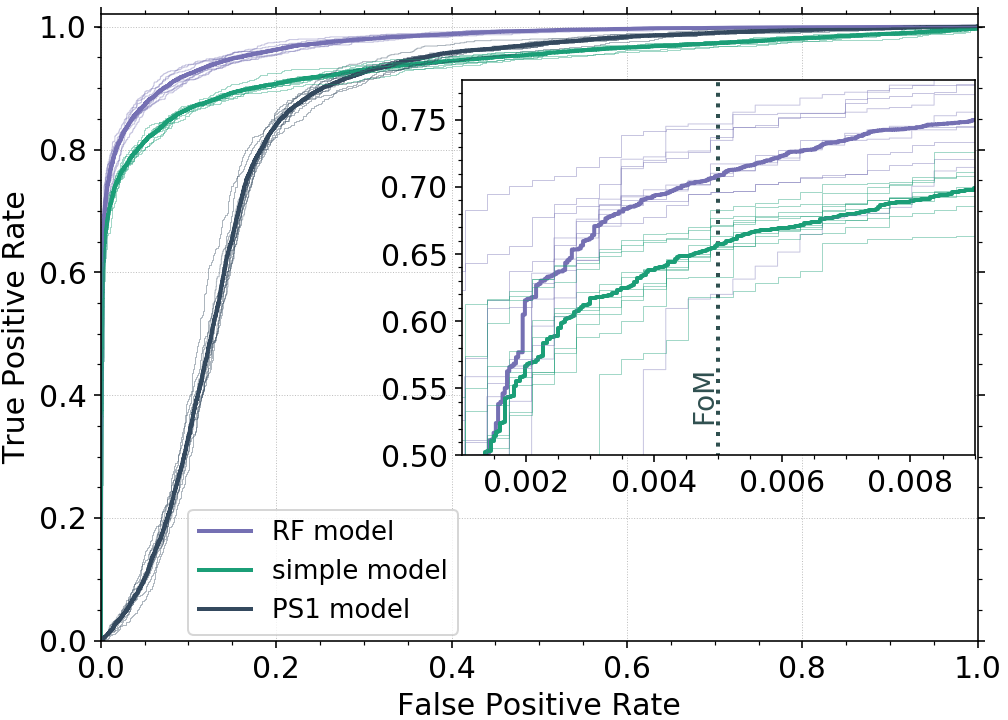

In [296]:
fig, main_ax = plt.subplots(figsize=(7,5))

axins = inset_axes(main_ax, width="58.5%",  
                   height="60%", loc=3,
                   bbox_to_anchor=(0.4, 0.28, 1., 1.),
                   bbox_transform=main_ax.transAxes)


cv = StratifiedKFold(n_splits=10, random_state=23)
X_hst = np.array(hst_tab[features].loc[hst_det_mask])

cv_summary_stats = calc_summary_stats(y_hst, ps1_preds, simple_preds, rf_preds, 
                                      make_plot=True, fold_plot=False)

for fold_num, (train, test) in enumerate(cv.split(X_hst, y_hst)):
    fold_results = calc_summary_stats(y_hst[test], ps1_preds[test], 
                                      simple_preds[test], rf_preds[test], make_plot=True)
    if fold_num == 0:
        each_fold_sum_stats = fold_results
    else:
        each_fold_sum_stats = np.vstack((each_fold_sum_stats, fold_results))



main_ax.set_xlim(0,1) 
main_ax.set_ylim(0,1.02)
main_ax.grid(alpha=0.5, lw=0.5, c='grey', linestyle=':') 
main_ax.tick_params(which="both", top=True, right=True, labelsize = 15)
main_ax.minorticks_on()
main_ax.set_xlabel('False Positive Rate', fontsize=15)
main_ax.set_ylabel('True Positive Rate', fontsize=15)

# legend stuff
main_ax.plot([1e6,1e6], [1e6,1e6], lw=2, 
        color="#7570b3", alpha=1,
        label='RF model')
main_ax.plot([1e6,1e6], [1e6,1e6], lw=2, 
        color="#1b9e77", alpha=1,
        label='simple model')
main_ax.plot([1e6,1e6], [1e6,1e6], lw=2, 
        color="#34495e", alpha=1,
        label='PS1 model')
main_ax.legend(loc=3, borderaxespad=0, fontsize=13,
               bbox_to_anchor=(0.1, 0.01, 1., 0.102), )
# SDSS color = #7570b3

        
# axins.vlines([5e-3], 1e-3, 1, color='grey', lw=0.5)
axins.vlines([5e-3], 1e-3, 1, 
          linestyles=":", 
          color='DarkSlateGrey', lw=2)
axins.text(5e-3, 0.55, 'FoM', 
        color='DarkSlateGrey', 
        rotation=90, ha="right", fontsize=14)

axins.set_xlim(1e-3, 9e-3)
axins.set_ylim(0.5, 0.78)
axins.tick_params(labelsize = 15)
axins.minorticks_on()

fig.subplots_adjust(right=0.97,top=0.98,bottom=0.11,left=0.1)
fig.savefig("/Users/adamamiller/Desktop/CV_ROC_HST.pdf")

In [191]:
print(r"""
RF & {0:.3f} $\pm$ {9:.3f} & {1:.3f} $\pm$ {10:.3f} & {2:.3f} $\pm$ {11:.3f} \\
simple & {3:.3f} $\pm$ {12:.3f} & {4:.3f} $\pm$ {13:.3f} & {5:.3f} $\pm$ {14:.3f} \\
PS1 & {6:.3f} $\pm$ {15:.3f} & {7:.3f} $\pm$ {16:.3f} & {8:.3f} $\pm$ {17:.3f} \\
""".format(*np.append(cv_summary_stats[::-1], np.std(each_fold_sum_stats, ddof=1, axis=0)[::-1])))


RF & 0.708 $\pm$ 0.037 & 0.932 $\pm$ 0.003 & 0.973 $\pm$ 0.002 \\
simple & 0.657 $\pm$ 0.020 & 0.916 $\pm$ 0.003 & 0.937 $\pm$ 0.004 \\
PS1 & 0.007 $\pm$ 0.003 & 0.784 $\pm$ 0.006 & 0.851 $\pm$ 0.006 \\

